In [15]:
import time
from datetime import datetime
from picamera import PiCamera
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imutils
import pickle
import os.path
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from googleapiclient.http import MediaFileUpload

gdfolder = '1crBqym6aiqByFbqcQn0pJkt2YRWDbVz7'
num_pictures = 10

#######################################################
# GDrive authorization
#######################################################
creds = []
SCOPES = ['https://www.googleapis.com/auth/drive.file']
if os.path.exists('token.pickle'):
    with open('token.pickle', 'rb') as token:
        creds = pickle.load(token)

if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file('credentials.json', SCOPES)
        creds = flow.run_local_server(port=0)
    
    with open('token.pickle', 'wb') as token:
        pickle.dump(creds, token)

drive = build('drive', 'v3', credentials=creds)


In [21]:
######################################################
# motion file setup
######################################################
# grab list of files that already exist
results = drive.files().list(fields="files(id, name)", q="'1crBqym6aiqByFbqcQn0pJkt2YRWDbVz7' in parents", orderBy='name').execute()['files']
gfiles = [results[ii]['id'] for ii in range(len(results)) if results[ii]['name'].startswith('motion')]

# make new placeholder files if necessary
for ii in range(len(gfiles), num_pictures):
    rc = cv2.imwrite('motion.jpg', (np.random.rand(200,300,3)*255).astype(int))
    media = MediaFileUpload('motion.jpg', mimetype='image/jpg')
    gfile = drive.files().create(body={'name': 'motion_%s.jpg' % str("{0:0=4d}".format(ii)), 'parents':[gdfolder]}, media_body=media, fields='id').execute()
    gfiles += [gfile]

In [22]:
#####################################################
# grab camera hardware and monitor
#####################################################
snapshot = np.empty((1024, 1280, 3), dtype=np.uint8)
background = None
box = (0, 1280, 350, 850)
gg = 0
prev_center, prev_timestamp = np.array([0,0]), 0.0
prev_cutout = np.zeros_like(snapshot, dtype=np.uint8)


#fig, ax = plt.subplots(figsize=(14, 14))
#ax.imshow(background)


In [57]:
with PiCamera(resolution=(1280, 1024)) as camera:
    time.sleep(2)
    try:
        while True:  #for ii in range(num_pictures):
            #print('processing image ' + str(ii+1), end='\r')
            time.sleep(0.25)
            camera.capture(snapshot, format='bgr', use_video_port=True)

            cutout = snapshot[box[2]:box[3], box[0]:box[1]]
            frame = cv2.cvtColor(cutout, cv2.COLOR_BGR2GRAY)
            frame = cv2.GaussianBlur(frame, (21, 21), 0)

            if background is None:
                background = frame.copy().astype('float')
            
            # compute the difference between the current frame and running average
            frameDelta = cv2.absdiff(frame, cv2.convertScaleAbs(background))
            
            # threshold the delta image, dilate the thresholded image to fill in holes,
            # then find contours on thresholded image
            thresh = cv2.threshold(frameDelta, 10, 255, cv2.THRESH_BINARY)[1]
            thresh = cv2.dilate(thresh, None, iterations=2)
            cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cnts = imutils.grab_contours(cnts)
            
            # look for large contour areas
            cnts = [cc for cc in cnts if cv2.contourArea(cc) > 300]
             
            # can only deal with one motion at a time
            if len(cnts) == 1:
                cc = cnts[0]
                
                # compute the bounding box for the contour, draw it on the frame, and update the text
                (xx, yy, ww, hh) = cv2.boundingRect(cc)
                center = np.array([xx + ww//2, yy + hh//2])
                timestamp = time.time()
                rc = cv2.rectangle(cutout, (xx, yy), (xx + ww, yy + hh), (0, 255, 0), 2)
            
                # last frame also had motion
                if motion:
                    distance = np.sqrt(np.sum( np.square(center - prev_center) ))
                    timedelta = timestamp - prev_timestamp
                    two_frame = np.concatenate((prev_cutout, np.zeros((80,cutout.shape[1],3), dtype=int)+255, cutout), axis=0)
                
                    imtxt = datetime.now().strftime('%Y-%m-%d %H:%M:%S') + '  ' + 'distance of {:1.0f} in {:3.1f} seconds'.format(distance, timedelta)
                    cv2.putText(two_frame, imtxt, (10,cutout.shape[0]+50), cv2.FONT_HERSHEY_DUPLEX, 1, 0) 
                    print('motion detected in image ' + str(gg) + '...' + imtxt, end='\r')
                
                    rc = cv2.imwrite('pictures/motion' + str(gg) + '.jpg', two_frame)
                    gg = (gg + 1) % num_pictures
                
                    prev_center = center
                    prev_timestamp = timestamp
                    prev_cutout = np.array(cutout)
                
                #media = MediaFileUpload('pictures/motion' + str(gg) + '.jpg', mimetype='image/jpg')
                #gfile = drive.files().update(fileId=gfiles[gg], media_body=media).execute()
                motion = True
            
            # set indicator for next frame
            else:
                motion = False
            
            # set background to current frame
            background = frame.copy().astype('float')
    
    except KeyboardInterrupt:
        pass


/usr/lib/python3/dist-packages/picamera/encoders.py:521: PiCameraAlphaStripping: using alpha-stripping to convert to non-alpha format; you may find the equivalent alpha format faster
  "using alpha-stripping to convert to non-alpha "


motion detected in image 0...distance of 308 in 0.5 seconds
motion detected in image 1...distance of 307 in 0.6 seconds
motion detected in image 2...distance of 341 in 0.6 seconds
motion detected in image 3...distance of 153 in 0.5 seconds
motion detected in image 4...distance of 2 in 0.5 seconds
motion detected in image 5...distance of 2 in 0.6 seconds
motion detected in image 6...distance of 1 in 0.6 seconds
motion detected in image 7...distance of 0 in 0.7 seconds
motion detected in image 8...distance of 1 in 0.6 seconds
motion detected in image 9...distance of 0 in 0.6 seconds
motion detected in image 10...distance of 0 in 0.6 seconds
motion detected in image 11...distance of 0 in 0.6 seconds
motion detected in image 12...distance of 0 in 0.6 seconds
motion detected in image 13...distance of 1 in 0.7 seconds
motion detected in image 14...distance of 1 in 0.6 seconds
motion detected in image 15...distance of 1 in 0.6 seconds
motion detected in image 16...distance of 1 in 0.6 seconds

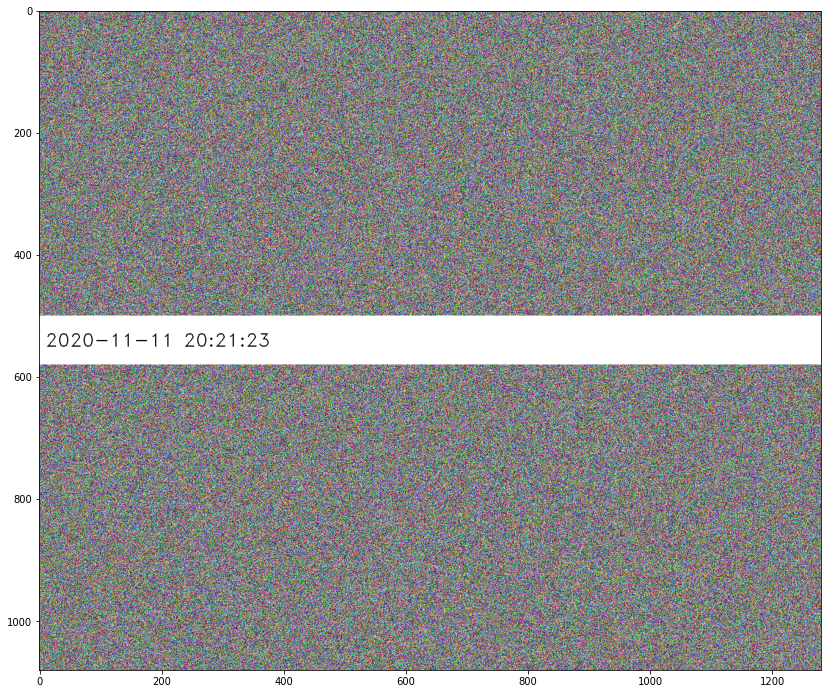

In [54]:
cutout = (np.random.rand(1024,1280,3)*255).astype(int)[box[2]:box[3], box[0]:box[1]]
two_frame = np.concatenate((cutout, np.zeros((80,cutout.shape[1],3), dtype=int)+255, cutout), axis=0)

cv2.putText(two_frame,datetime.now().strftime('%Y-%m-%d %H:%M:%S'), (10,cutout.shape[0]+50), cv2.FONT_HERSHEY_DUPLEX, 1, 0)

fig, ax = plt.subplots(figsize=(14, 14))
ax.imshow(two_frame)

In [35]:
plt.savefig('text.jpg')

<Figure size 432x288 with 0 Axes>

In [59]:
for ii in range(num_pictures):
    print('uploading ' + str(ii+1), end='\r')
    if os.path.exists('pictures/motion' + str(ii) + '.jpg'):
        media = MediaFileUpload('pictures/motion' + str(ii) + '.jpg', mimetype='image/jpg')
        gfile = drive.files().update(fileId=gfiles[ii], media_body=media).execute()
            